<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Next-Steps:" data-toc-modified-id="Next-Steps:-1">Next Steps:</a></span></li><li><span><a href="#Time-Series-EDA" data-toc-modified-id="Time-Series-EDA-2">Time Series EDA</a></span><ul class="toc-item"><li><span><a href="#Trend-in-mean-browser-cpm" data-toc-modified-id="Trend-in-mean-browser-cpm-2.1">Trend in mean browser cpm</a></span><ul class="toc-item"><li><span><a href="#Trend-of-median-CPM-for-top-5-browsers" data-toc-modified-id="Trend-of-median-CPM-for-top-5-browsers-2.1.1">Trend of median CPM for top 5 browsers</a></span></li></ul></li><li><span><a href="#Trend-of-the-mean-CPMs-per-creative-size" data-toc-modified-id="Trend-of-the-mean-CPMs-per-creative-size-2.2">Trend of the mean CPMs per creative size</a></span></li></ul></li><li><span><a href="#Model-Building" data-toc-modified-id="Model-Building-3">Model Building</a></span><ul class="toc-item"><li><span><a href="#Categorical-Encoding" data-toc-modified-id="Categorical-Encoding-3.1">Categorical Encoding</a></span></li><li><span><a href="#Train-Validation-split" data-toc-modified-id="Train-Validation-split-3.2">Train-Validation split</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3">CatBoostRegressor</a></span></li></ul></li></ul></div>

## Next Steps:
    1. Perform time-Series EDA to see if next day's CPM is related to the previous CPM.
    2. Validation set must be almost identical to the Test set. 
        Use 27/08/2020 for validation
    3. Investigate CatBoostRegressor and LightGBMRegressor
        - Try HyperParameter tuning.
        - Investigate how to apply regularization using these algos.
    4. See performance of model such as.
        - Mean Absolute Error.
        - Plot y_pred and y_test to assess performance.
        - Check RMSE against 75% percentile.
    5. If this doesnt workout split the model into IO_IDs 
        and train separate model on each. Split the validation set in 
        the same way and use for prediction.
    6. Ignore line_item_id.
        
    

## Time Series EDA

In [75]:
import pandas as pd
import numpy as np

In [76]:
df = pd.read_csv('../data/train.csv')

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397023 entries, 0 to 1397022
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Line Item ID         1397023 non-null  int64  
 1   Date                 1397023 non-null  object 
 2   App/URL ID           1397023 non-null  object 
 3   ISP or Carrier ID    1397023 non-null  int64  
 4   Device Type          1397023 non-null  object 
 5   Exchange ID          1397023 non-null  int64  
 6   Operating System     1397023 non-null  object 
 7   Browser              1397023 non-null  object 
 8   Creative Size        1397023 non-null  object 
 9   Advertiser Currency  1397023 non-null  object 
 10  Impressions          1397023 non-null  int64  
 11  IO_ID                1397023 non-null  int64  
 12  CPM                  1397023 non-null  float64
dtypes: float64(1), int64(5), object(7)
memory usage: 138.6+ MB


In [78]:
df.drop(['IO_ID', 'Line Item ID'], axis = 1, inplace = True)

In [79]:
df.columns = ['date', 'app_url_id', 'isp_or_carrier_id',
              'device_type', 'exchange_id', 'operating_system', 'browser',
              'creative_size', 'advertiser_currency', 'impressions', 'cpm']

In [80]:
# Change dtype of date
df['date'] = pd.to_datetime(df['date'], format = '%d-%m-%Y')
# get day of week
import datetime as dt
df['day_of_week'] = df['date'].dt.day_name()

In [81]:
# drop app/urls which are unknown, since its a very small fraction of the total data
unknown_app_ids = df[df['app_url_id'] == 'Unknown'].index
df.drop(unknown_app_ids, axis = 0, inplace = True)

In [82]:
# convert dtype of app_url_id
df['app_url_id'] = pd.to_numeric(df['app_url_id'])

In [83]:
df.head()

,date,app_url_id,isp_or_carrier_id,device_type,exchange_id,operating_system,browser,creative_size,advertiser_currency,impressions,cpm,day_of_week
0,2020-08-17,1.516400e+11,1000,Desktop,1,Macintosh,Chrome,728x90,CAD,2,0.0105,Monday
1,2020-08-17,1.362606e+09,1000,Desktop,1,Windows 10,Chrome,300x600,CAD,2,0.0125,Monday
2,2020-08-17,2.030382e+10,207,Desktop,1,Windows 7,Chrome,160x600,CAD,2,0.0200,Monday
3,2020-08-17,2.030382e+10,666,Desktop,1,Windows 10,Chrome,160x600,CAD,2,0.0350,Monday
4,2020-08-17,2.030382e+10,1000,Desktop,1,Windows 10,Chrome,160x600,CAD,4,0.0220,Monday


### Trend in mean browser cpm

In [84]:
# top 5 broswer CPMs
browser_cpm = df.groupby('browser', as_index = False)\
.mean()[['browser', 'cpm']].sort_values('cpm', ascending = False)
browser_cpm.head()

,browser,cpm
7,Internet Explorer 9,3.072000
1,Chrome,2.254010
9,Opera,2.056699
11,Safari,1.982352
15,Safari 13,1.874712


#### Trend of median CPM for top 5 browsers

C:\Users\blahb\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


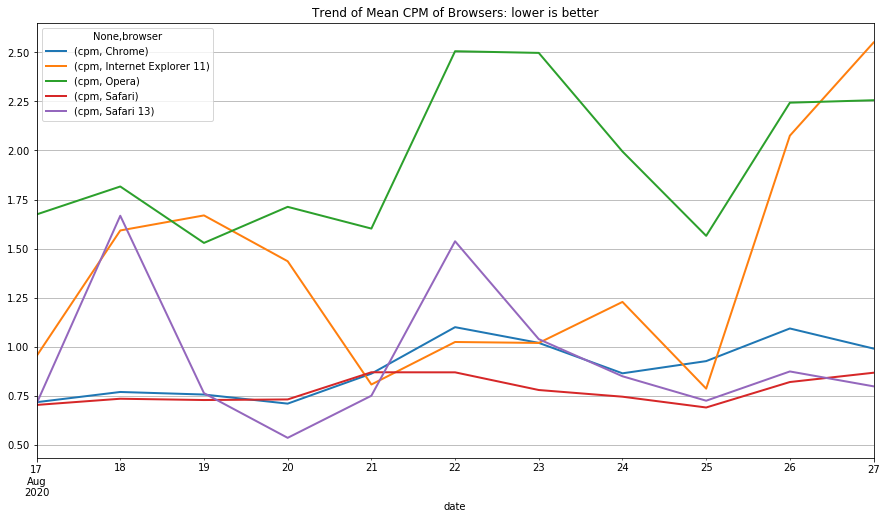

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
top_browser_list = list(browser_cpm['browser'].iloc[1:6])

browser_cpm_trend = pd.DataFrame(df[(df['browser'].isin(top_browser_list))])[['date', 'browser', 'cpm']]\
.groupby(['date', 'browser'])['browser', 'cpm'].median().unstack()

browser_cpm_trend.plot(figsize = (15, 8), linewidth = 2, grid = True,
                      title = 'Trend of Mean CPM of Browsers: lower is better')
plt.show()

    The trend looks erratic but in this timeframe there is a reduction in 
    the mean CPM towards the end.
    - mean CPM for the famous browsers like Chrome, Safari dropped towards the end.

### Trend of the mean CPMs per creative size

In [86]:
# top 5 broswer CPMs
creative_cpm = df.groupby('creative_size', as_index = False)\
.mean()[['creative_size', 'cpm']].sort_values('cpm', ascending = False)

creative_cpm.head()

,creative_size,cpm
2,300x250,2.624440
6,970x250,2.132086
3,300x600,2.062848
1,160x600,1.984722
5,728x90,1.559829


C:\Users\blahb\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


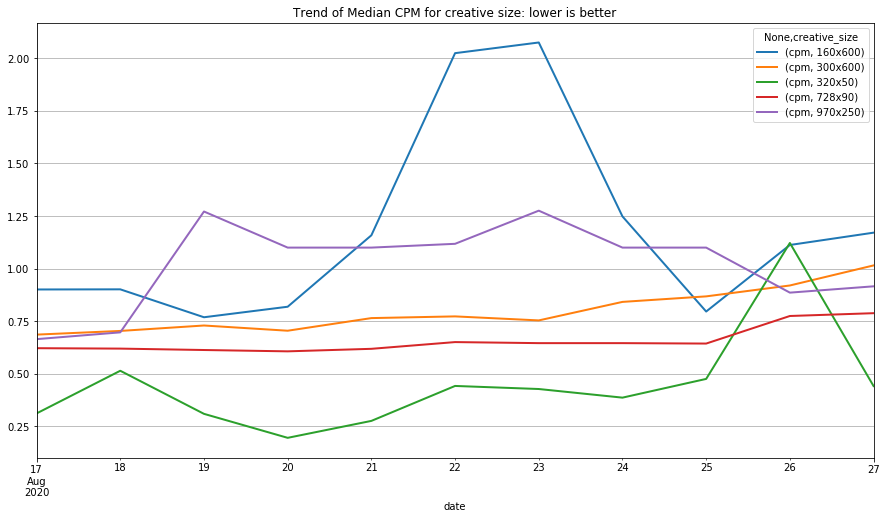

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
creative_cpm_list = list(creative_cpm['creative_size'].iloc[1:6])

browser_cpm_trend = pd.DataFrame(df[(df['creative_size'].isin(creative_cpm_list))])\
[['date', 'creative_size', 'cpm']]\
.groupby(['date', 'creative_size'])['creative_size', 'cpm'].median().unstack()

browser_cpm_trend.plot(figsize = (15, 8), linewidth = 2, grid = True,
                      title = 'Trend of Median CPM for creative size: lower is better')
plt.show()

    The median CPM of most creative size remains stable over this time-frame.
    except 160x600
    

## Model Building

### Categorical Encoding

In [88]:
df_org = df.copy()

In [89]:
from sklearn.preprocessing import OrdinalEncoder
categorical = ['app_url_id', 'isp_or_carrier_id', 'device_type', 
               'exchange_id','operating_system', 'browser', 
               'creative_size', 'advertiser_currency','day_of_week']
enc = OrdinalEncoder()

df[categorical] = enc.fit_transform(df[categorical])

In [90]:
df.isnull().sum()

date                   0
app_url_id             0
isp_or_carrier_id      0
device_type            0
exchange_id            0
operating_system       0
browser                0
creative_size          0
advertiser_currency    0
impressions            0
cpm                    0
day_of_week            0
dtype: int64

### Train-Validation split
    Use '2020-08-27' for validation

In [91]:
# Take 27/08/2020 as test dataset
df_test = df[df['date'] == '2020-08-27'].copy()
df_train = df.drop(df_test.index, axis = 0) 

# Separate train and test data into predictors and target
y_train = df_train['cpm']
df_train.drop(['date', 'cpm'], axis = 1, inplace = True)

y_test = df_test['cpm']
df_test.drop(['cpm', 'date'], axis = 1, inplace = True)

print(df_train.shape, df_test.shape)

(1221473, 10) (170451, 10)


### CatBoostRegressor

In [92]:
from catboost import CatBoostRegressor

In [93]:
df_train[categorical] = df_train[categorical].apply(pd.to_numeric, downcast = 'integer')

In [98]:
df_test[categorical] = df_test[categorical].apply(pd.to_numeric, downcast = 'integer')

In [99]:
df_test.isnull().sum()

app_url_id             0
isp_or_carrier_id      0
device_type            0
exchange_id            0
operating_system       0
browser                0
creative_size          0
advertiser_currency    0
impressions            0
day_of_week            0
dtype: int64

In [95]:
cbr = CatBoostRegressor(logging_level='Silent', random_state=100)

In [96]:
cbr.fit(df_train, y_train, cat_features = categorical, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [100]:
cbr_pred = cbr.predict(df_test, verbose = True)

In [103]:
pd.Series(cbr_pred, name = 'cpm').to_csv('base_cbr_predict.csv', 
                                         index_label='id', header = True)